# Reviewing the results
In this notebook the Omnibus F-test map is shown (corrected for multiple comparisons) and then I attempt to relate it to the individual pairwise t-tests. It is important to realize that just because the F-test is significant, we're not guaranteed to have a significant difference in individual paired comparisons between questionnares.

**Omnibus F-test**: Detects whether there is any difference among the group means at a voxel.
* Significant F means: there is some effect in the voxel, but it doesn’t specify which pairs differ.
* It can be significant even if none of the pre-defined pairwise contrasts reach the threshold individually — for example, when small, distributed differences combine to give a significant F.

**Pairwise T-tests**: Examine specific differences between two conditions/contrasts.
* Significant T means: that specific contrast differs.
* T-tests can be non-significant even where F is significant, especially if effects are small and distributed.

## Layout of notebook
1. **Omnibus F-test result**
2. **Paired comparisons (all questionnaire pairs)**
3. **Relating paired comparisons to Omnibus F result**

In [1]:
from glob import glob
from itertools import combinations
from pathlib import Path
import matplotlib.pyplot as plt
from nilearn.image import math_img, new_img_like
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn.image import load_img, math_img
from nilearn.plotting import plot_roi, plot_stat_map
from nilearn.reporting import get_clusters_table

from survey_medley_code.config_loader import load_config

In [2]:
cfg = load_config()

In [3]:
outdir = cfg.output_root / 'within_subject_question_estimates'

In [4]:
omnibus_pmap_file = outdir / 'group_f_test/glm_tfce_1minuspvalue_fstat_omnibusf.nii.gz'
omnibus_fmap_file = outdir / 'group_f_test/glm_fstat_omnibusf.nii.gz'

paired_outdir = outdir / 'all_paired_t_tests'

### 1. Omnibus F-test results

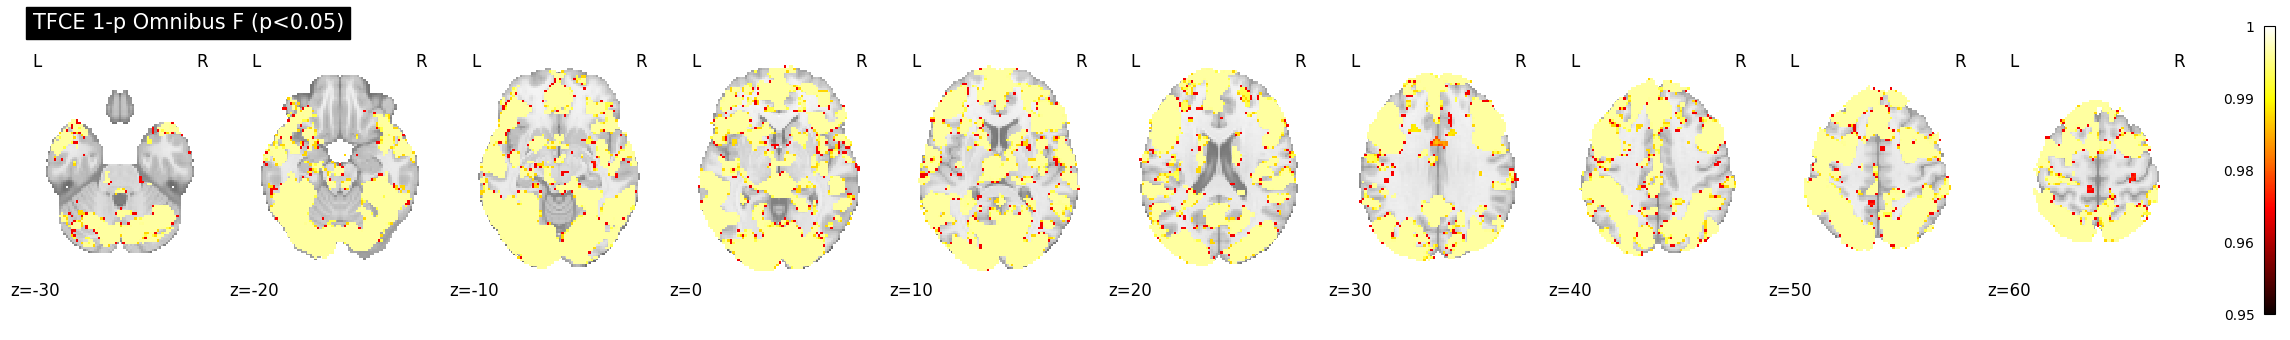

In [5]:
# omnibus = load_img(omnibus_pmap_file)

z_slices = list(range(-30, 61, 10))
threshold = 0.95

plot_stat_map(
    omnibus_pmap_file,
    threshold=threshold,
    display_mode='z',
    cut_coords=z_slices,
    colorbar=True,
    vmin=0.95,
    vmax=1.005,
    symmetric_cbar=False,
    cmap='hot',
    title=f'TFCE 1-p Omnibus F (p<{(1 - threshold):.2f})',
)
plt.show()

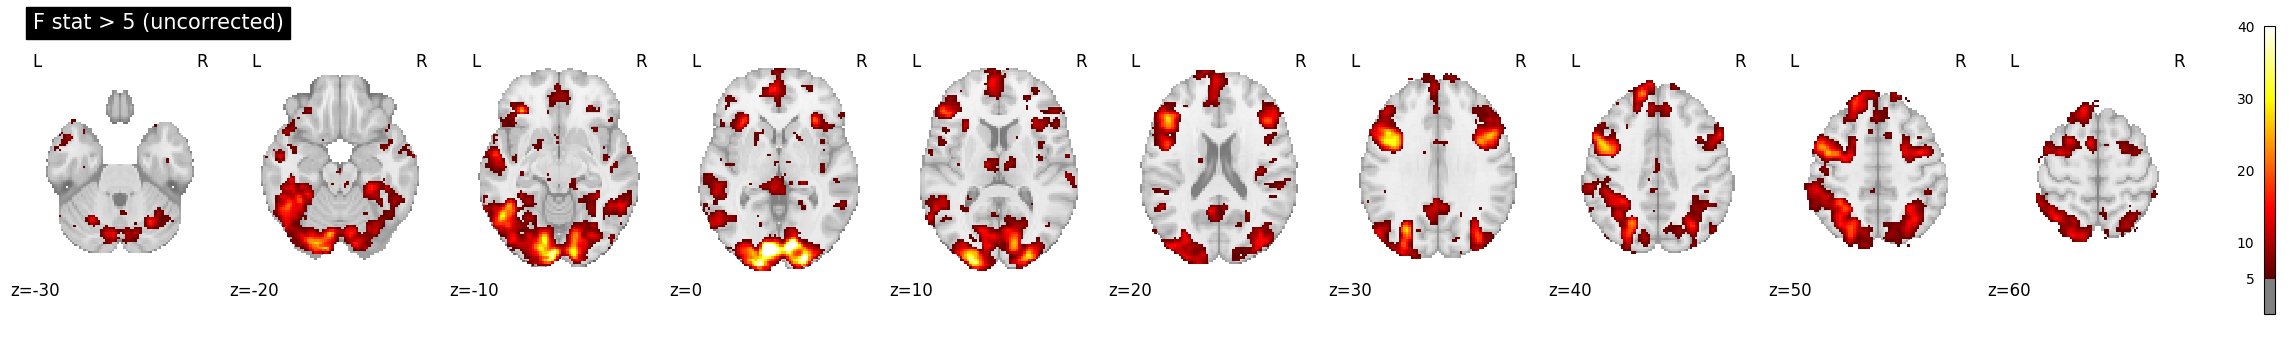

In [6]:
fthresh = 5

plot_stat_map(
    omnibus_fmap_file,
    threshold=fthresh,
    display_mode='z',
    cut_coords=z_slices,
    colorbar=True,
    title=f'F stat > {fthresh} (uncorrected)',
    vmin=0,
    vmax=40,
    symmetric_cbar=False,
    cmap='hot',
)
plt.show()

### 2. Paired comparisons (all questionnaire pairs)

In [7]:
questionnaire_names = ['brief', 'future_time', 'grit', 'impulsive_venture', 'upps']

question_pmaps = {}
question_tmaps = {}

for qa, qb in combinations(questionnaire_names, 2):
    pairing_name = f'{qa}_minus_{qb}'
    paired_pmap_loop = (
        paired_outdir
        / f'paired_test_{pairing_name}/onesample_2sided_tfce_corrp_fstat1.nii.gz'
    )
    paired_t_loop = (
        paired_outdir / f'paired_test_{pairing_name}/uncorrected_tstat1.nii.gz'
    )

    question_pmaps[pairing_name] = paired_pmap_loop
    question_tmaps[pairing_name] = paired_t_loop


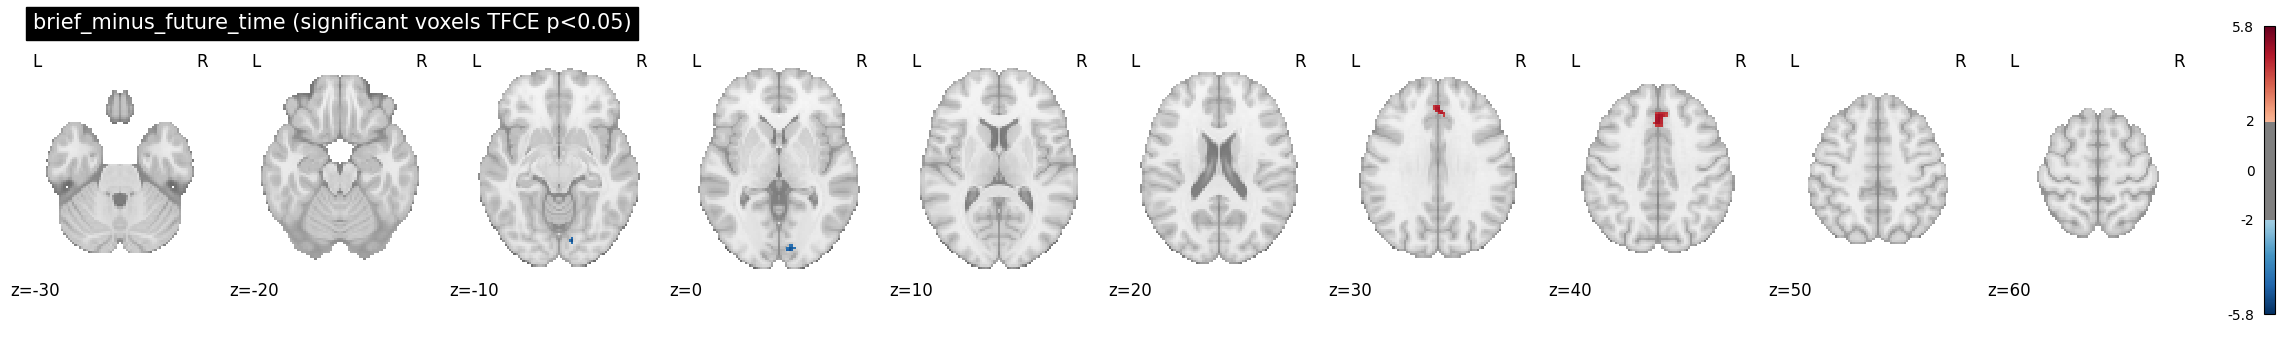

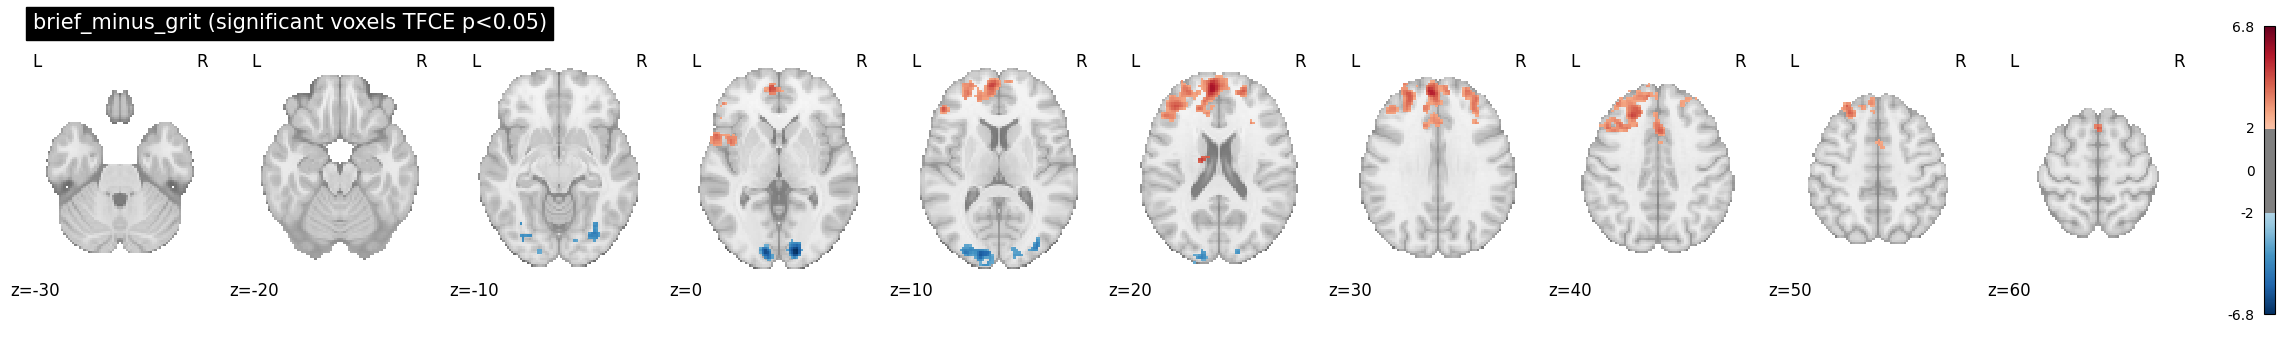

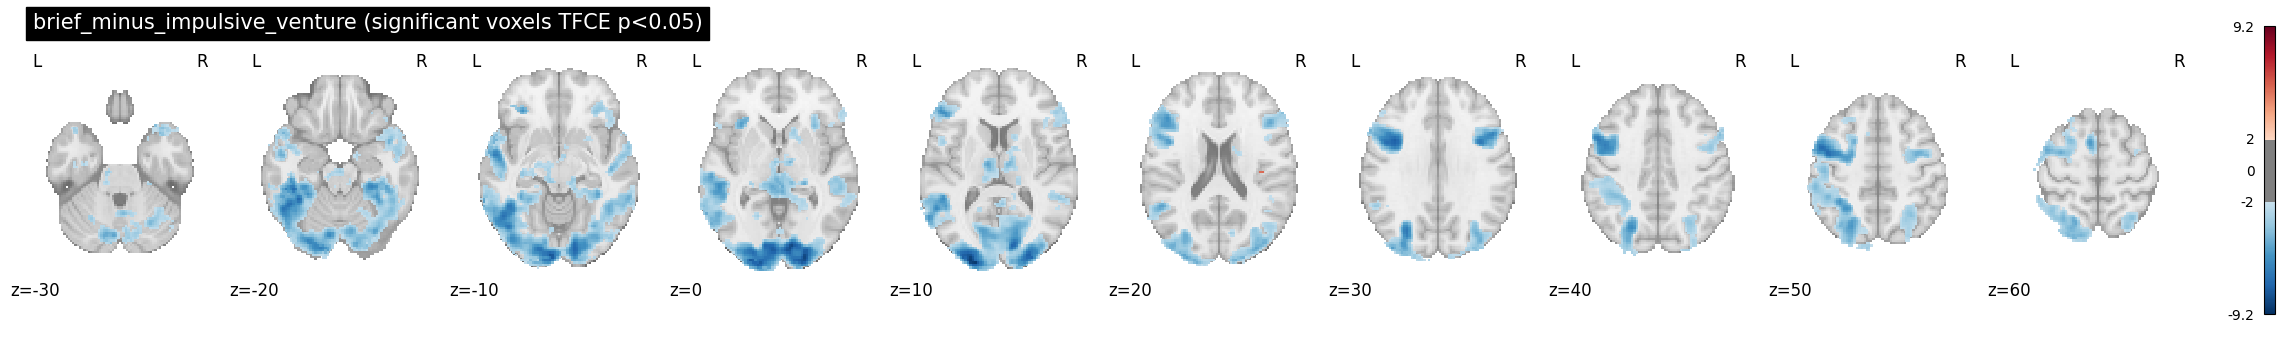

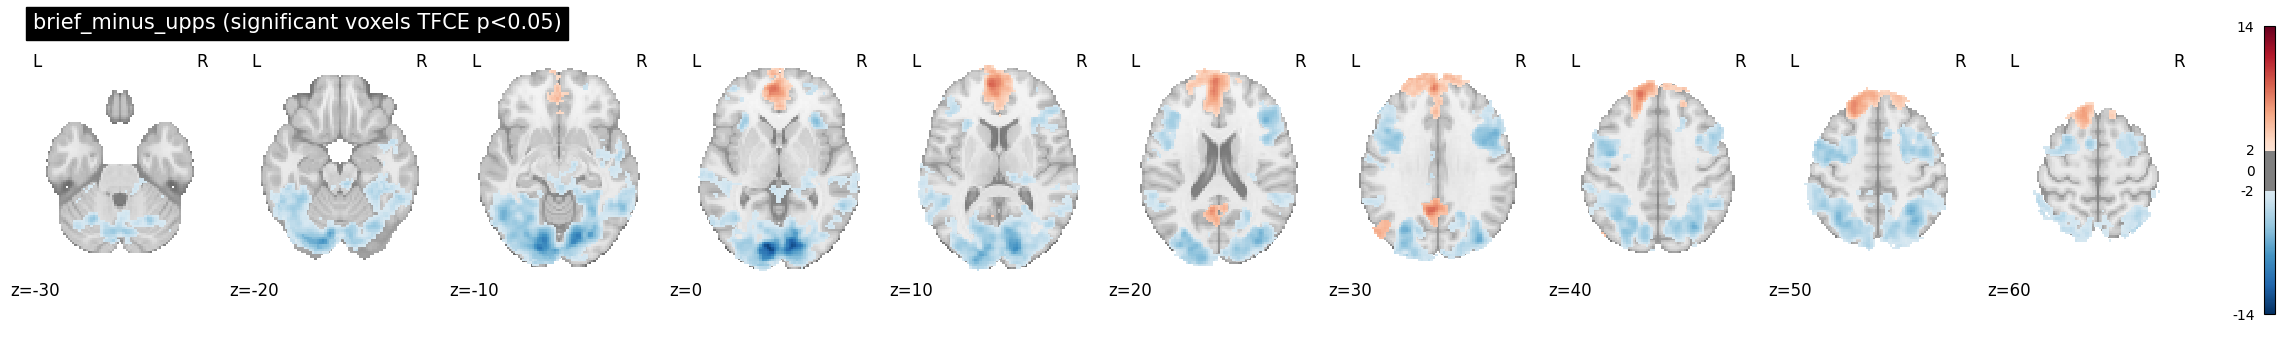

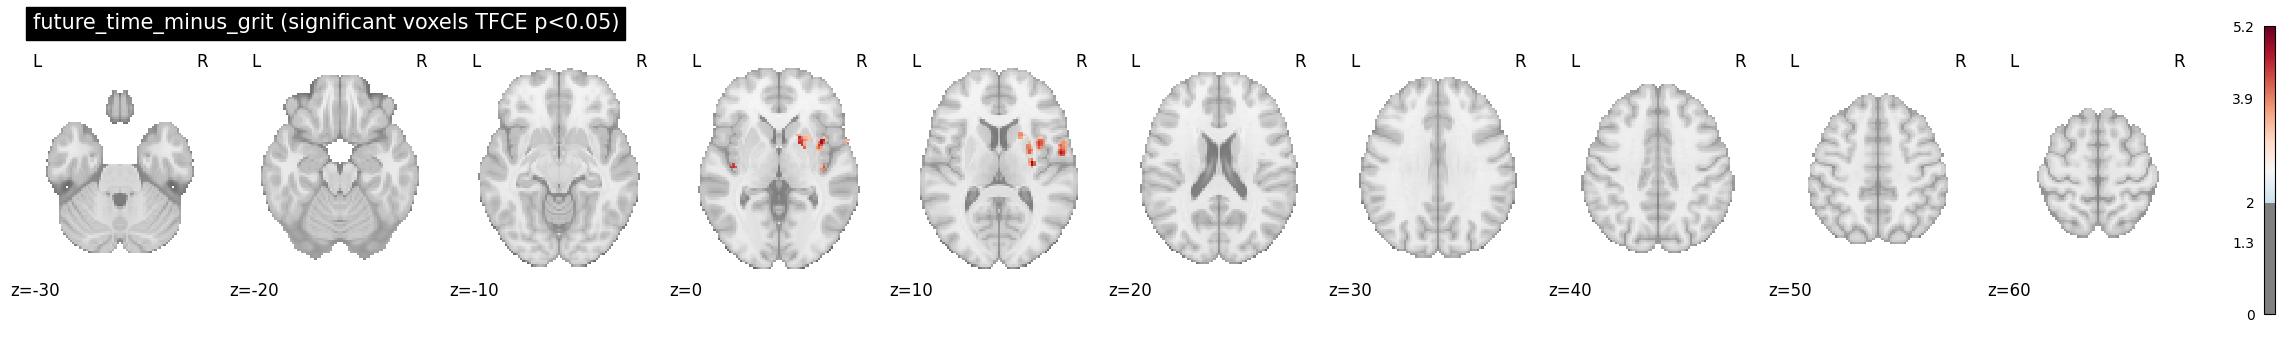

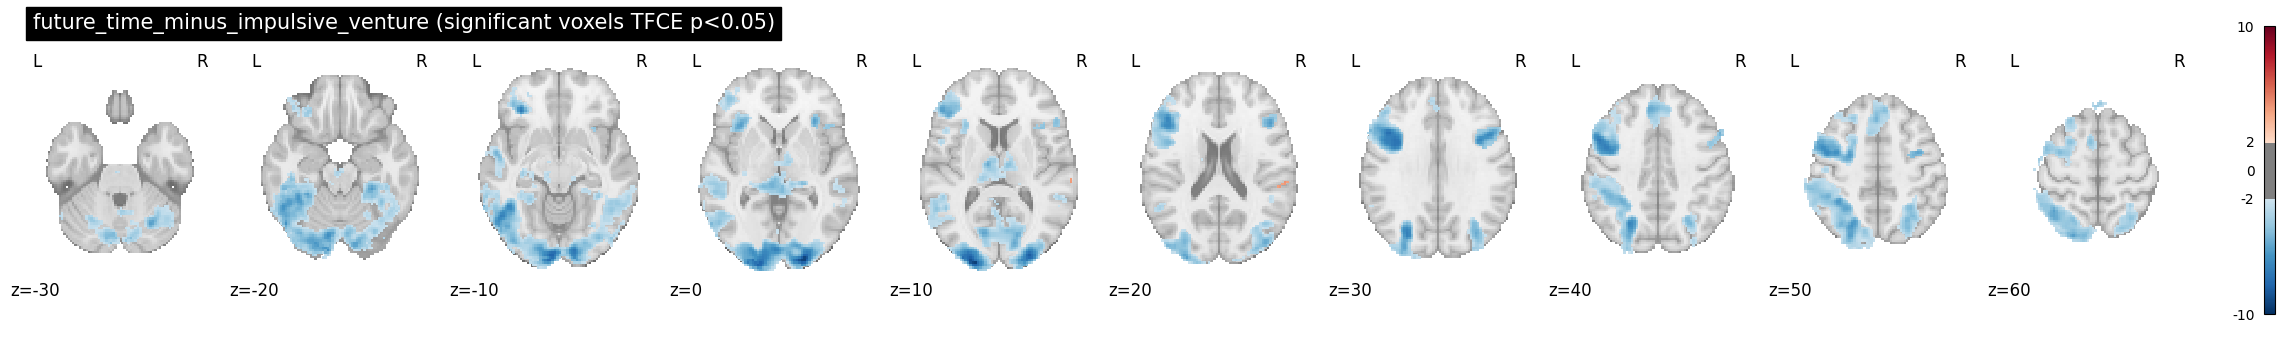

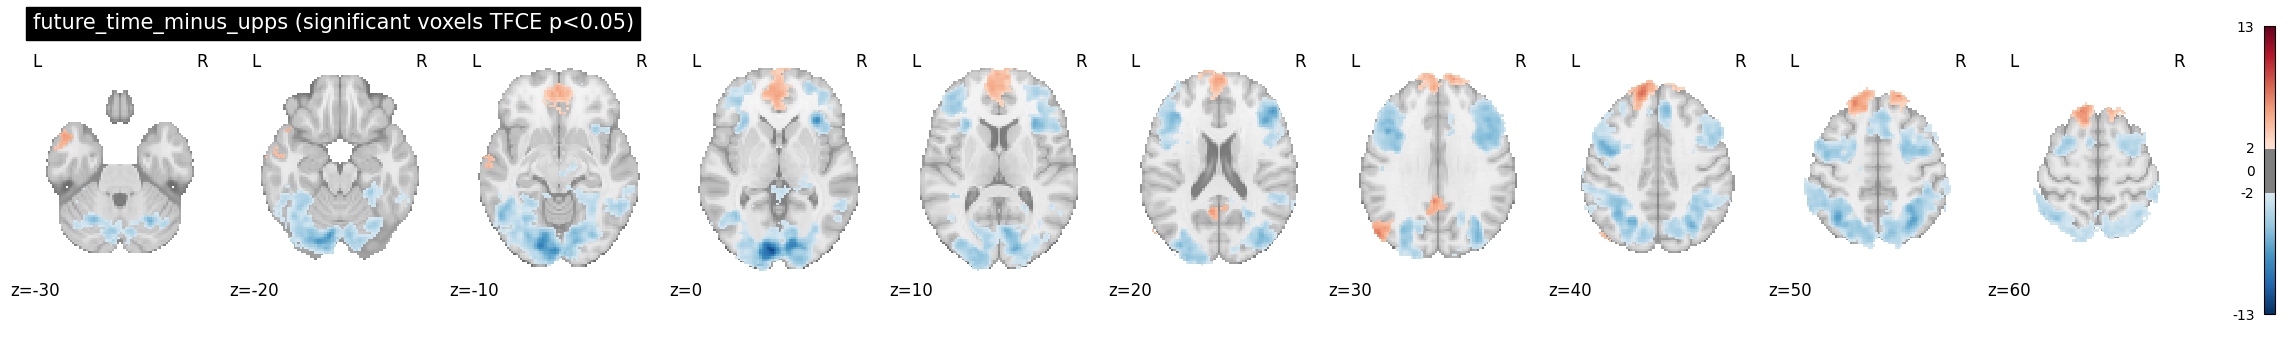

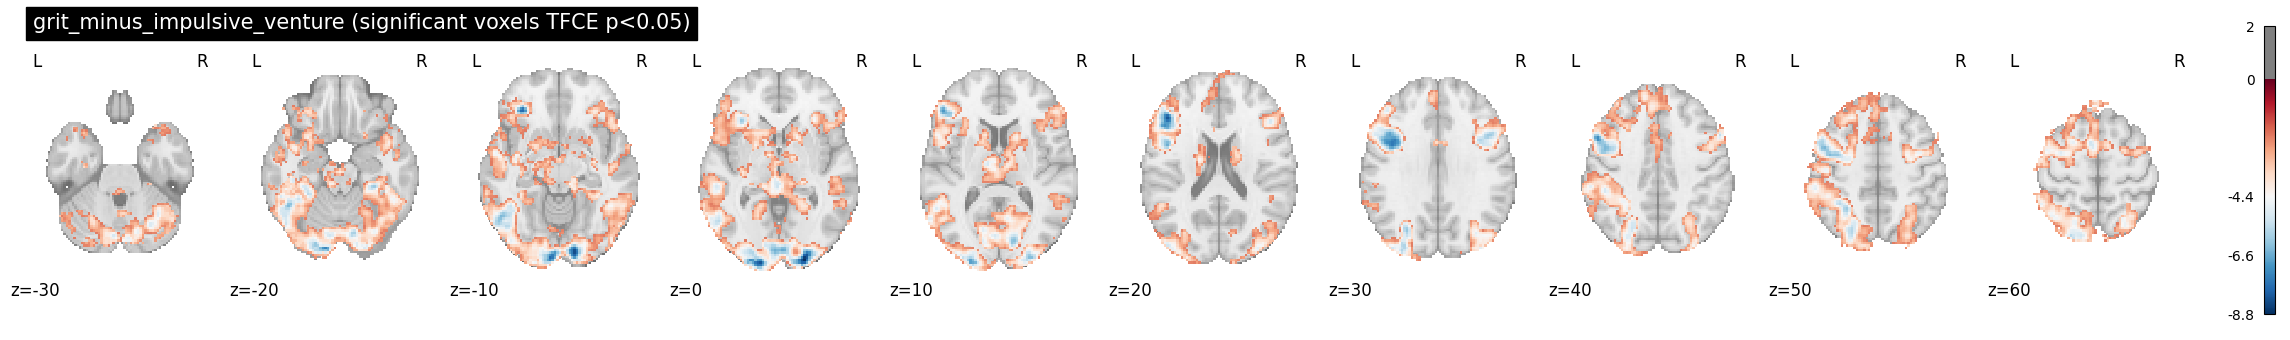

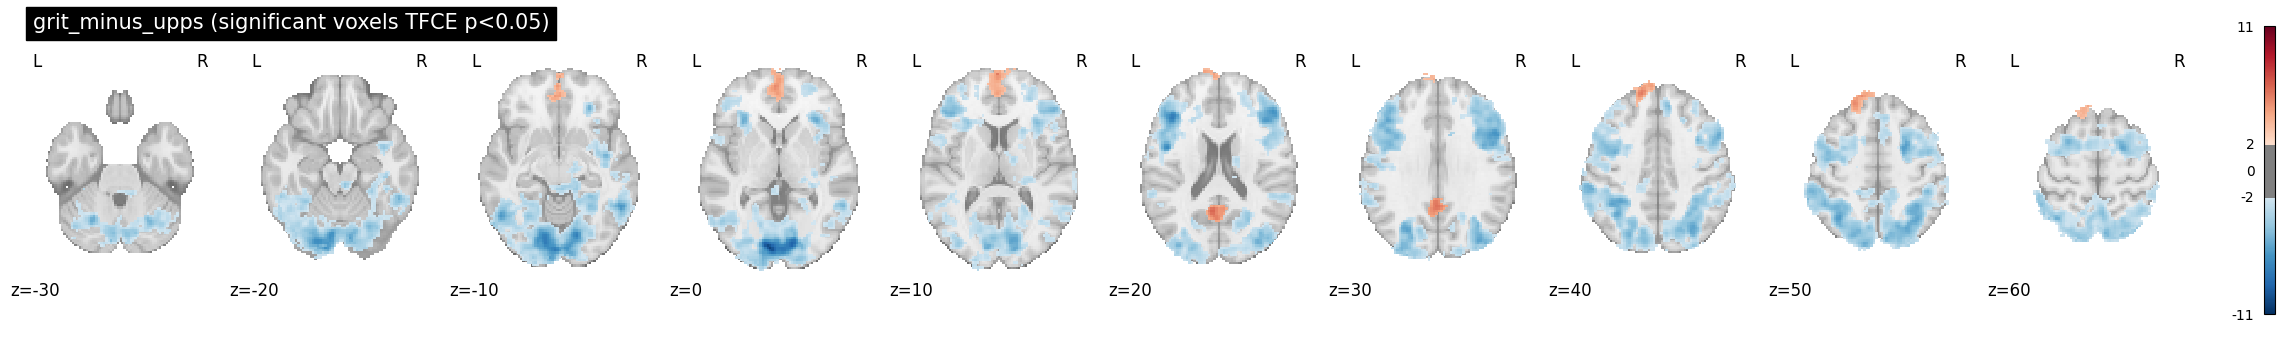

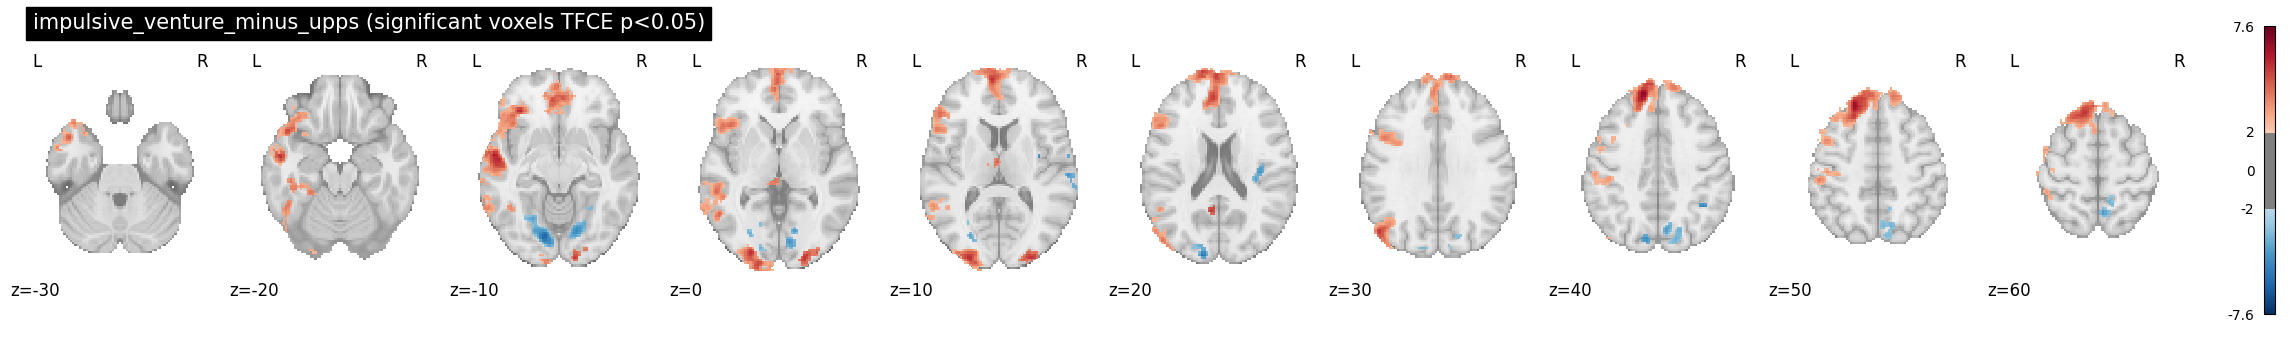

In [8]:
bon_thresh = 1 - (0.05)

binary_paired_maps = {}

for label, map in question_pmaps.items():
    tmap = load_img(question_tmaps[label])
    pmap = load_img(map)
    # Threshold and binarize pmap at 0.95, then multiply by fmap
    img = math_img(f'img_t * (img_p > {bon_thresh})', img_t=tmap, img_p=pmap)

    # Create positive and negative binary maps
    pos_binary = math_img('img > 0', img=img)
    neg_binary = math_img('img < 0', img=img)

    pos_key = label.replace('_minus_', ' > ')
    binary_paired_maps[pos_key] = pos_binary

    # Negative map
    neg_key = label.replace('_minus_', ' < ')
    binary_paired_maps[neg_key] = neg_binary

    plot_stat_map(
        img,
        threshold=2,
        display_mode='z',
        cut_coords=z_slices,
        colorbar=True,
        title=f'{label} (significant voxels TFCE p<{1 - bon_thresh:.3})',
    )
    plt.show()

### 3. Relating paired comparisons to Omnibus F result

For each paired comparison, we identify the voxels that are significant in both the pairwise t-test and the omnibus F-test. This procedure is repeated for all paired comparisons. For each voxel, an integer encodes which paired comparisons are significant at that location.

Although there are many possible combinations (we split the 10 comparisons into positive and negative directions, giving 20 possibilities), if I restrict to overlaps that have a least one connected component with > 150 voxels, there aren't too many to plot.

In [9]:
# binary_paired_maps: dictionary of binary maps
binary_f_map = math_img('img > .95', img=omnibus_pmap_file)

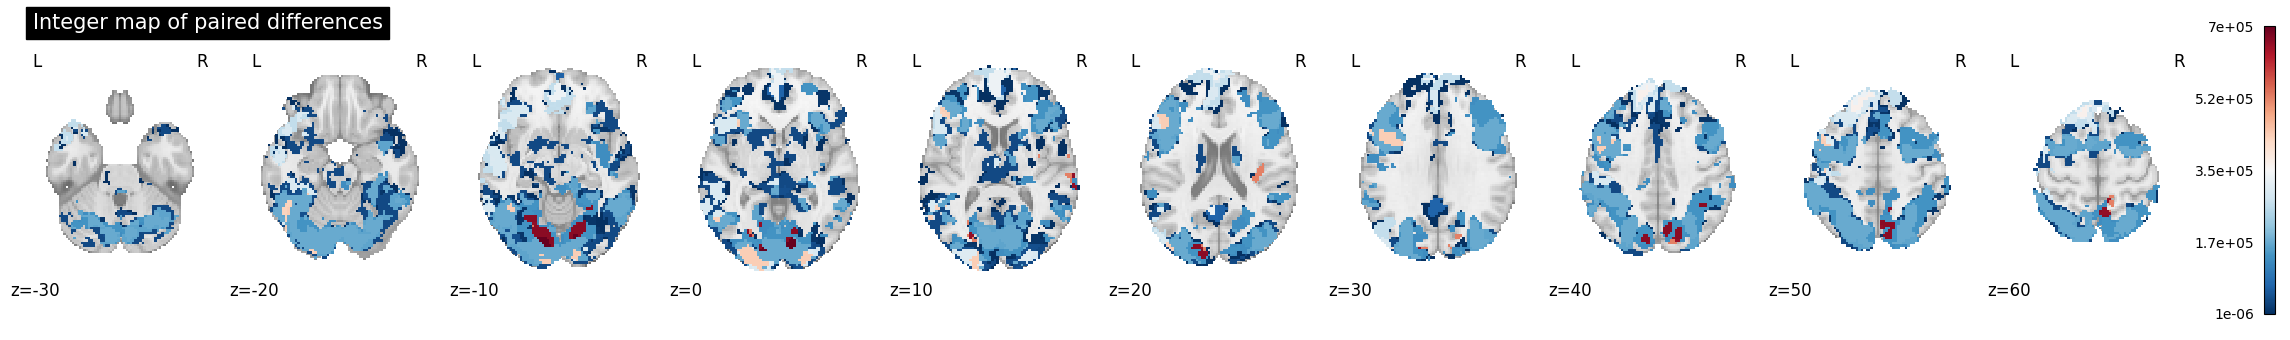

In [10]:
pair_names = list(binary_paired_maps.keys())
n_pairs = len(pair_names)

# Create an empty integer map
data_shape = binary_f_map.shape
integer_map = np.zeros(data_shape, dtype=np.int32)

# Loop through each pair and set the corresponding bit
for bit_idx, pair in enumerate(pair_names):
    pair_data = binary_paired_maps[pair].get_fdata()
    pair_data_bin = (pair_data > 0).astype(np.int32)  # ensure 0 or 1
    integer_map += pair_data_bin * (2**bit_idx)

# Mask to include only voxels significant in the omnibus F
f_data = binary_f_map.get_fdata()
integer_map = integer_map * (f_data > 0).astype(np.int32)

# Create a new Nifti image
integer_img = new_img_like(binary_f_map, integer_map)

# Plot the integer map (hard to tell what is waht)
plot_stat_map(
    integer_img,
    title='Integer map of paired differences',
    display_mode='z',
    cut_coords=z_slices,
)
plt.show()


In [11]:
# Count number of unique values and voxel counts
unique_vals, counts = np.unique(integer_map, return_counts=True)
voxel_counts = dict(zip(unique_vals, counts))
print('Voxel counts for each combination:')
for val, count in voxel_counts.items():
    print(f'Integer {val}: {count} voxels')

# Create a dictionary to interpret integer values
interpret_dict = {}
for val in unique_vals:
    included_pairs = [pair_names[i] for i in range(n_pairs) if (val >> i) & 1]
    if not included_pairs:
        included_pairs = [
            'F only'
        ]  # category for F-significant voxels with no paired difference
    interpret_dict[val] = included_pairs


Voxel counts for each combination:
Integer 0: 760284 voxels
Integer 1: 13 voxels
Integer 4: 393 voxels
Integer 5: 11 voxels
Integer 16: 1 voxels
Integer 32: 904 voxels
Integer 40: 3 voxels
Integer 64: 791 voxels
Integer 65: 12 voxels
Integer 68: 367 voxels
Integer 69: 7 voxels
Integer 128: 1120 voxels
Integer 136: 2 voxels
Integer 160: 658 voxels
Integer 168: 22 voxels
Integer 256: 281 voxels
Integer 1024: 16 voxels
Integer 2048: 358 voxels
Integer 2049: 10 voxels
Integer 2052: 6 voxels
Integer 2053: 11 voxels
Integer 2080: 314 voxels
Integer 2088: 1 voxels
Integer 2113: 1 voxels
Integer 2117: 2 voxels
Integer 2176: 6 voxels
Integer 2208: 144 voxels
Integer 2216: 7 voxels
Integer 4096: 410 voxels
Integer 4128: 1 voxels
Integer 4160: 571 voxels
Integer 4164: 137 voxels
Integer 8192: 788 voxels
Integer 8193: 13 voxels
Integer 8196: 26 voxels
Integer 8224: 4 voxels
Integer 8320: 832 voxels
Integer 8328: 11 voxels
Integer 8352: 137 voxels
Integer 8360: 50 voxels
Integer 10240: 206 voxels
I

Integer 32: 904 voxels -> brief < impulsive_venture (largest cluster: 211)


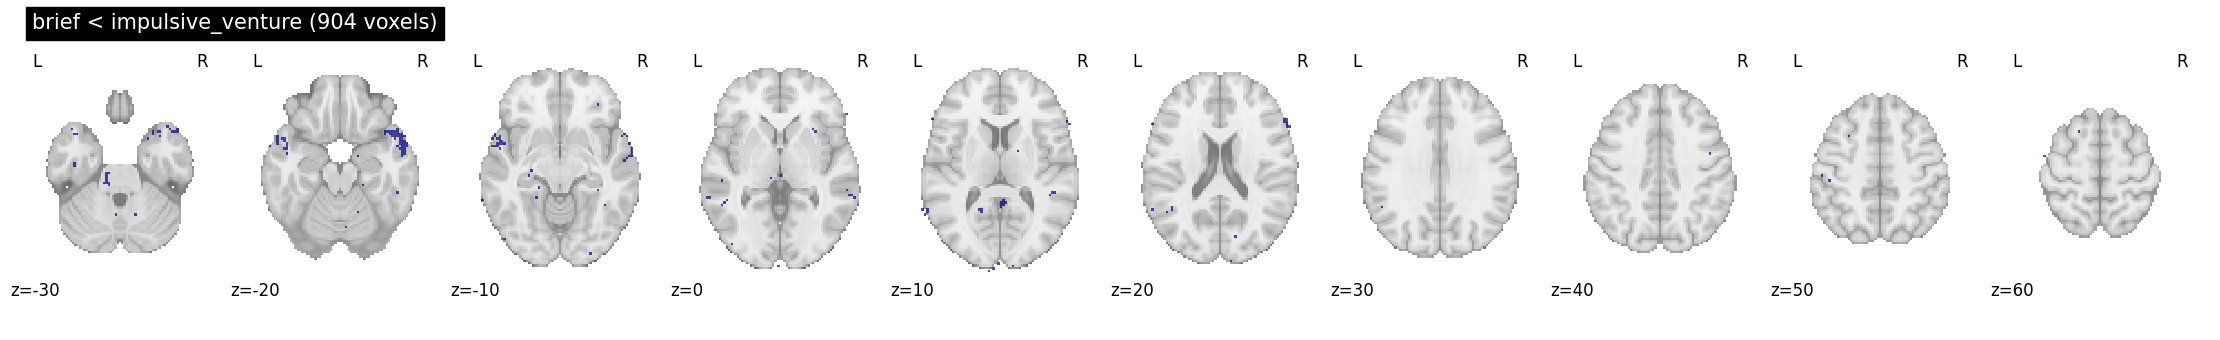

Integer 64: 791 voxels -> brief > upps (largest cluster: 210)


/oak/stanford/groups/russpold/data/uh2/aim1/analysis_code/survey_medley_code/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2896: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


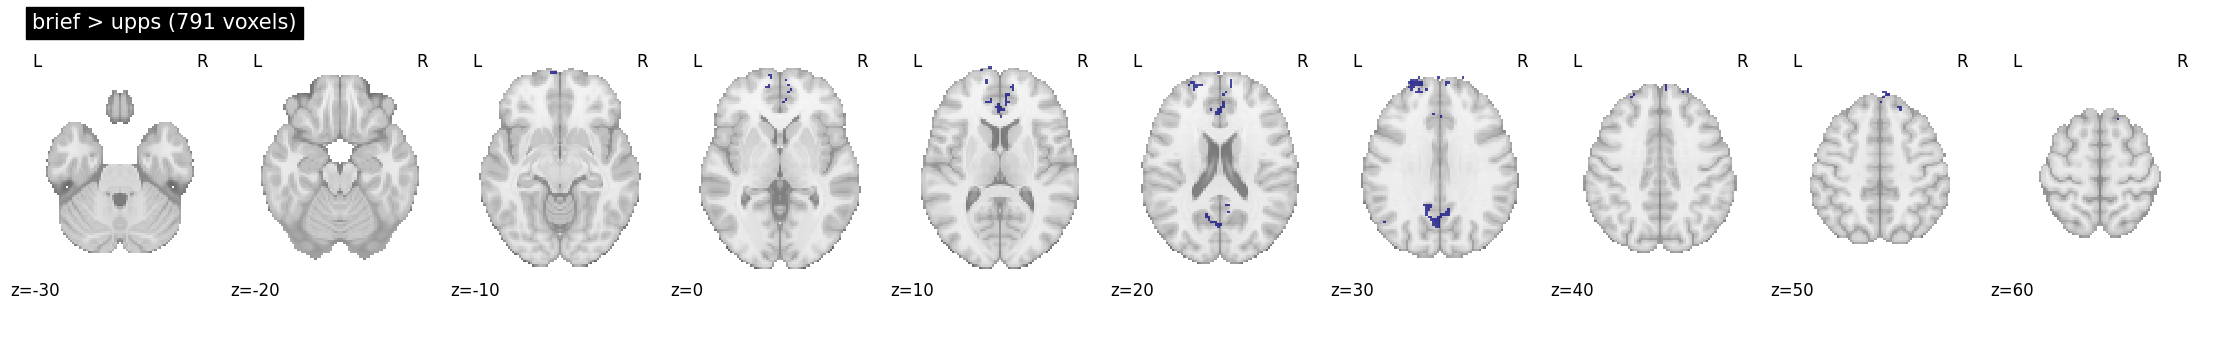

Integer 4160: 571 voxels -> brief > upps, future_time > upps (largest cluster: 279)


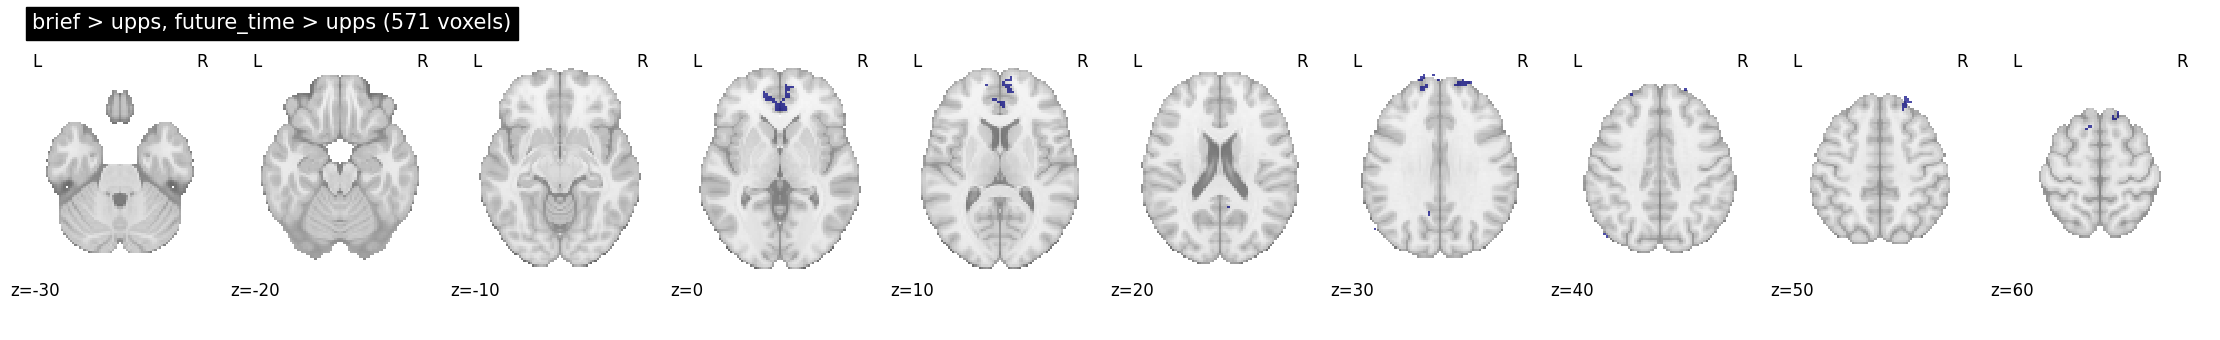

Integer 8192: 788 voxels -> future_time < upps (largest cluster: 197)


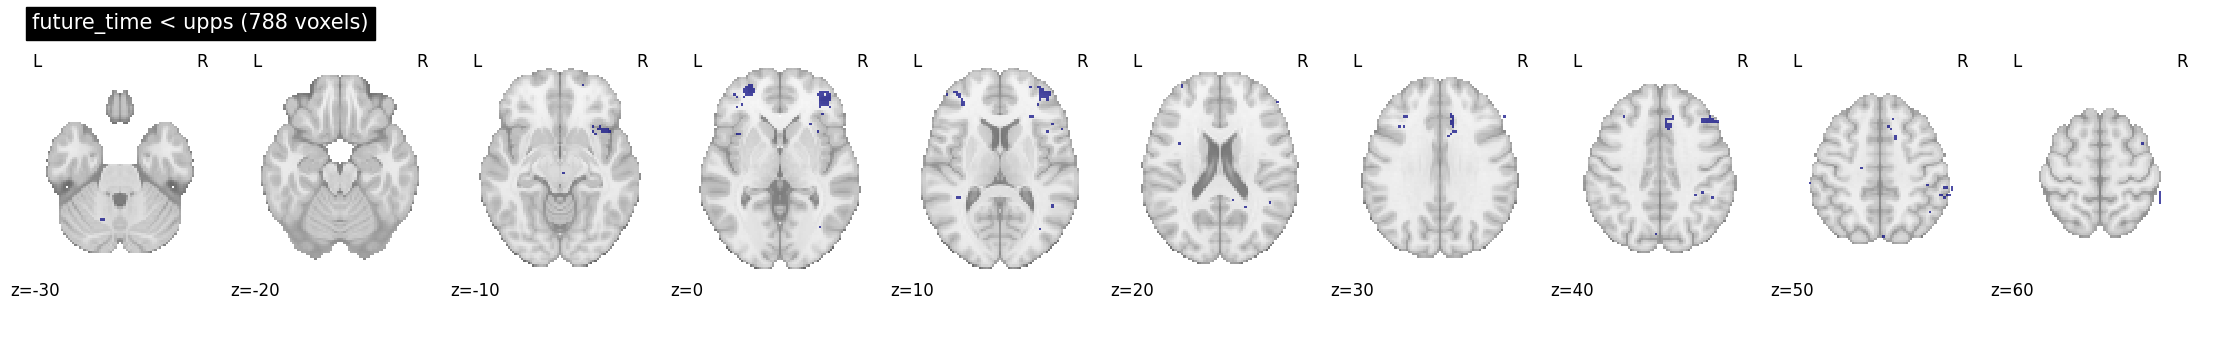

Integer 32768: 4038 voxels -> grit < impulsive_venture (largest cluster: 1139)


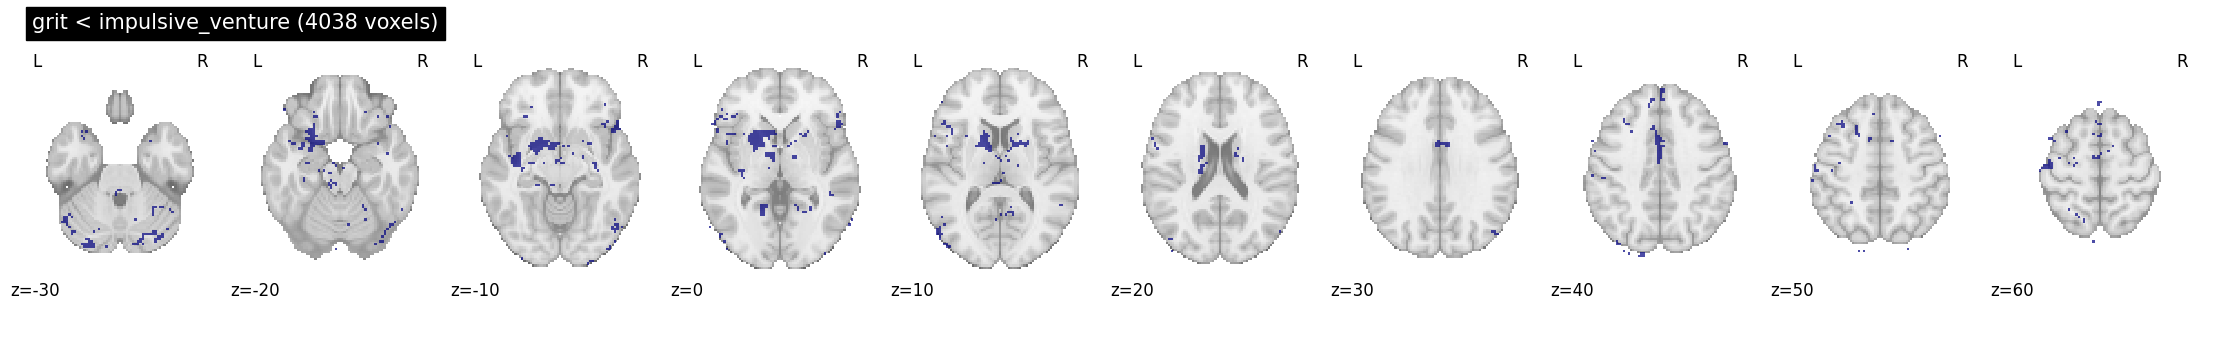

Integer 32800: 2424 voxels -> brief < impulsive_venture, grit < impulsive_venture (largest cluster: 220)


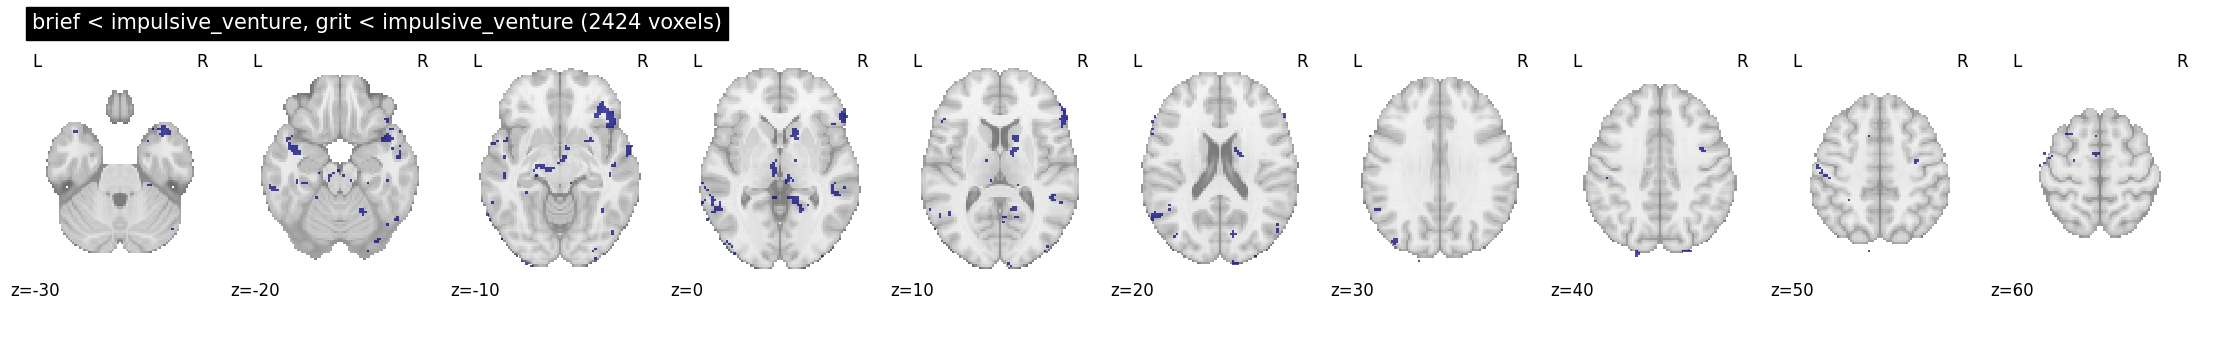

Integer 34848: 2903 voxels -> brief < impulsive_venture, future_time < impulsive_venture, grit < impulsive_venture (largest cluster: 596)


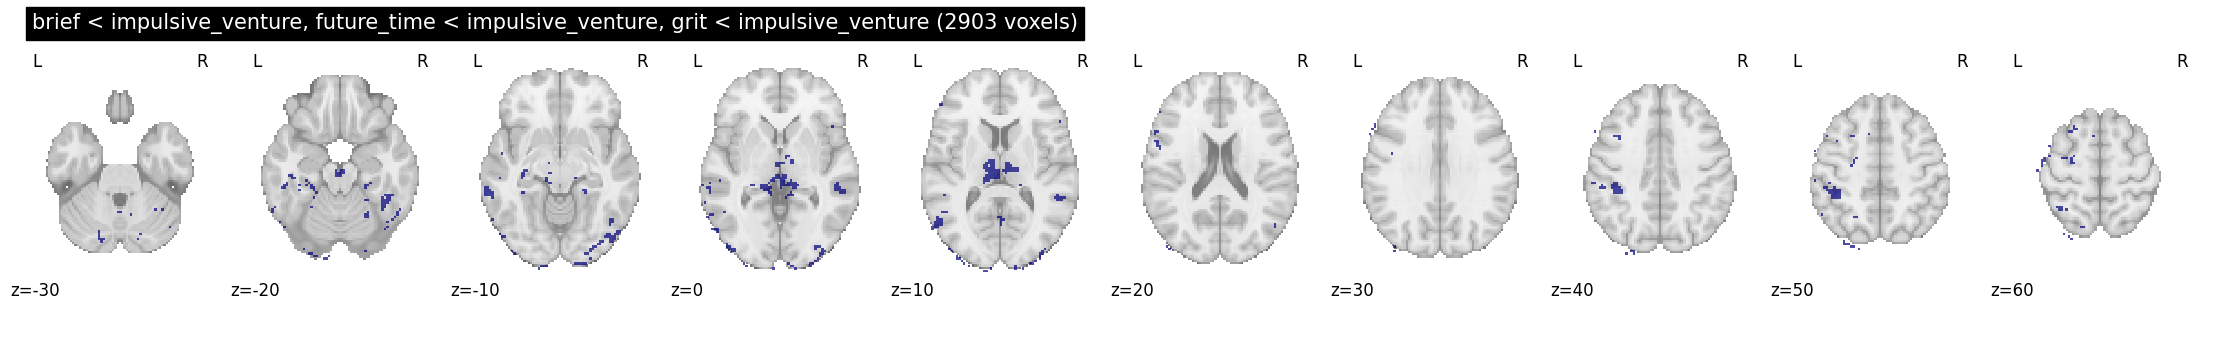

Integer 69696: 246 voxels -> brief > upps, future_time > upps, grit > upps (largest cluster: 183)


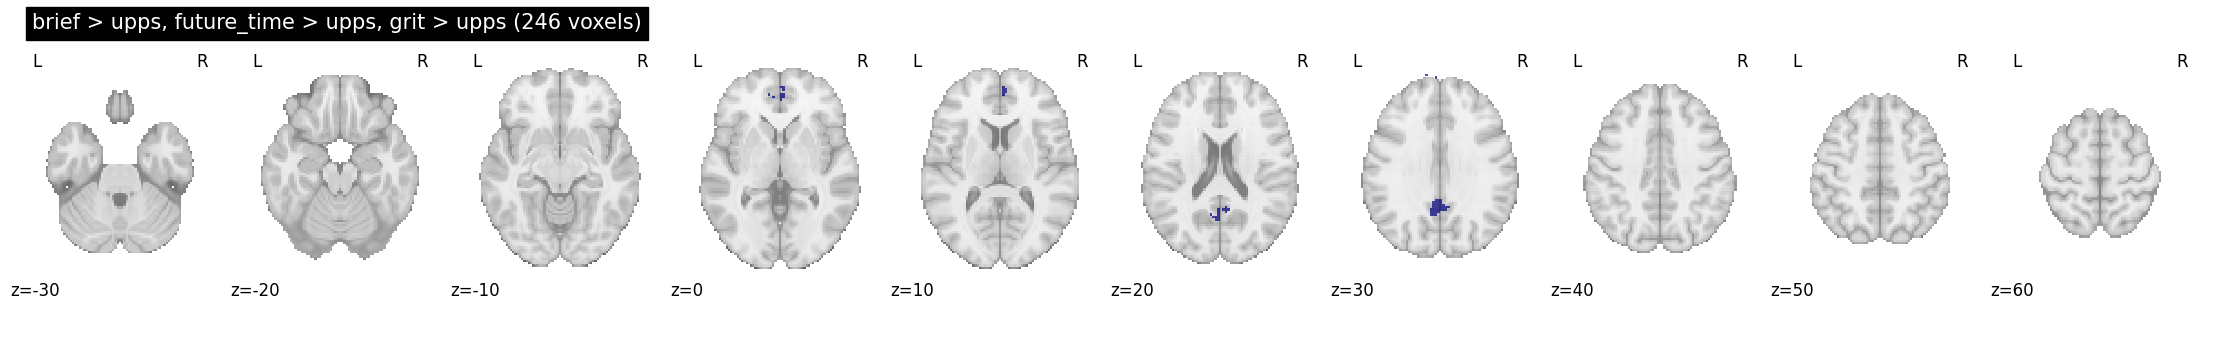

Integer 139264: 1730 voxels -> future_time < upps, grit < upps (largest cluster: 569)


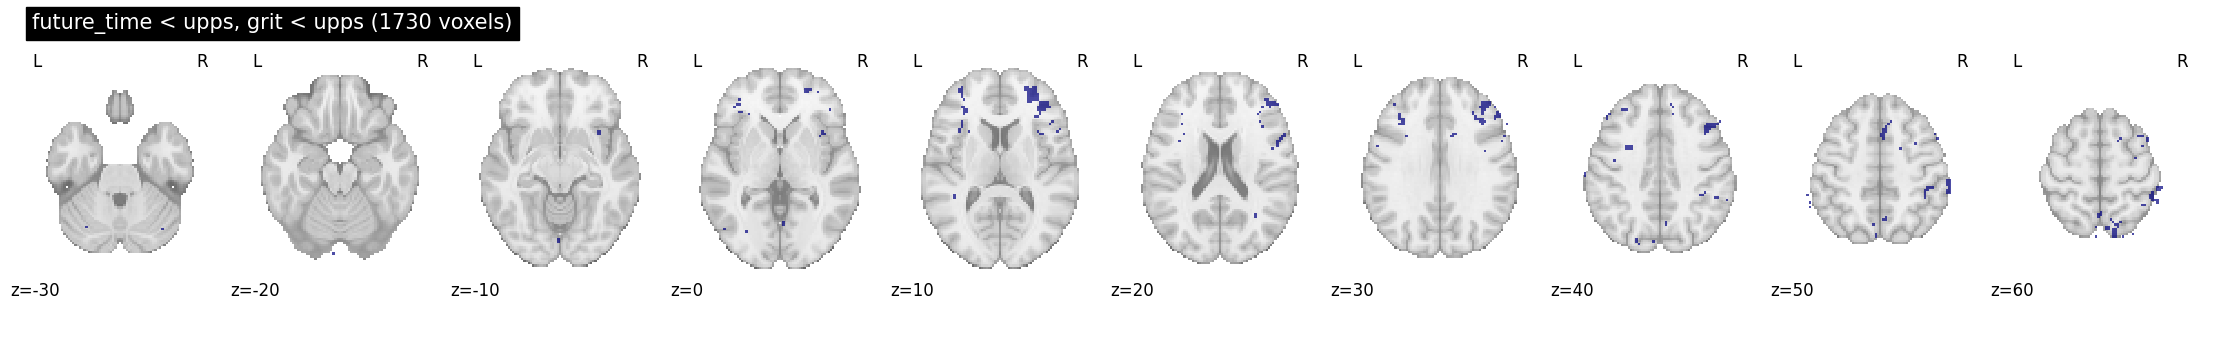

Integer 139392: 6067 voxels -> brief < upps, future_time < upps, grit < upps (largest cluster: 1123)


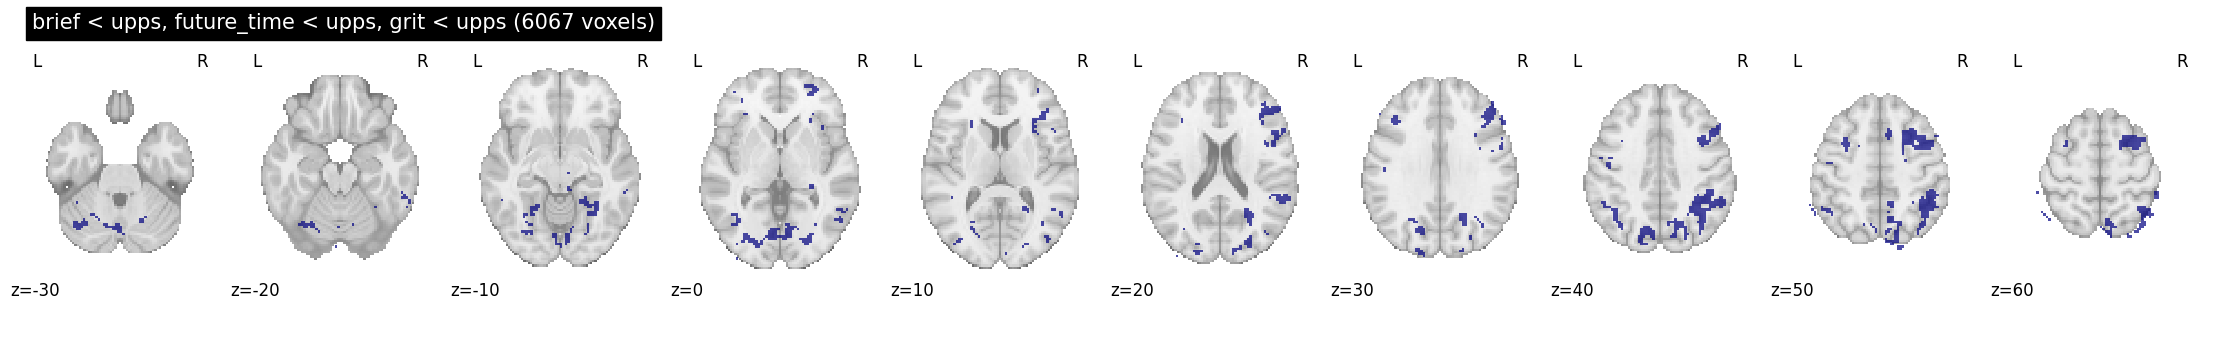

Integer 172192: 1008 voxels -> brief < impulsive_venture, brief < upps, future_time < upps, grit < impulsive_venture, grit < upps (largest cluster: 170)


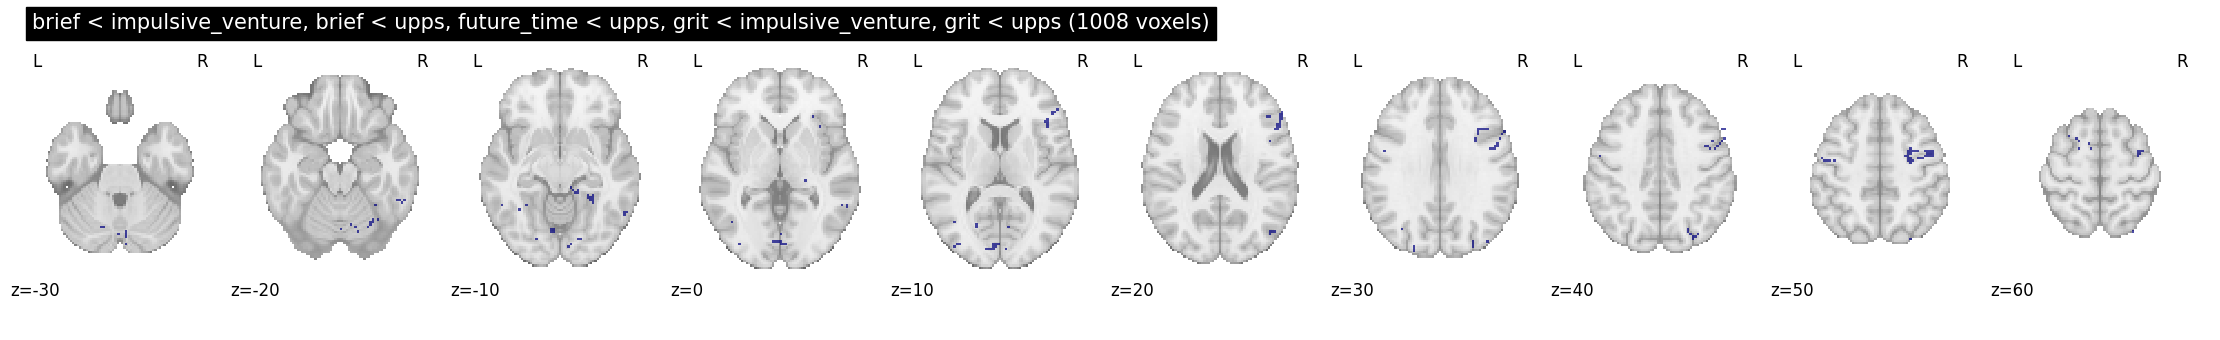

Integer 174240: 11302 voxels -> brief < impulsive_venture, brief < upps, future_time < impulsive_venture, future_time < upps, grit < impulsive_venture, grit < upps (largest cluster: 7022)


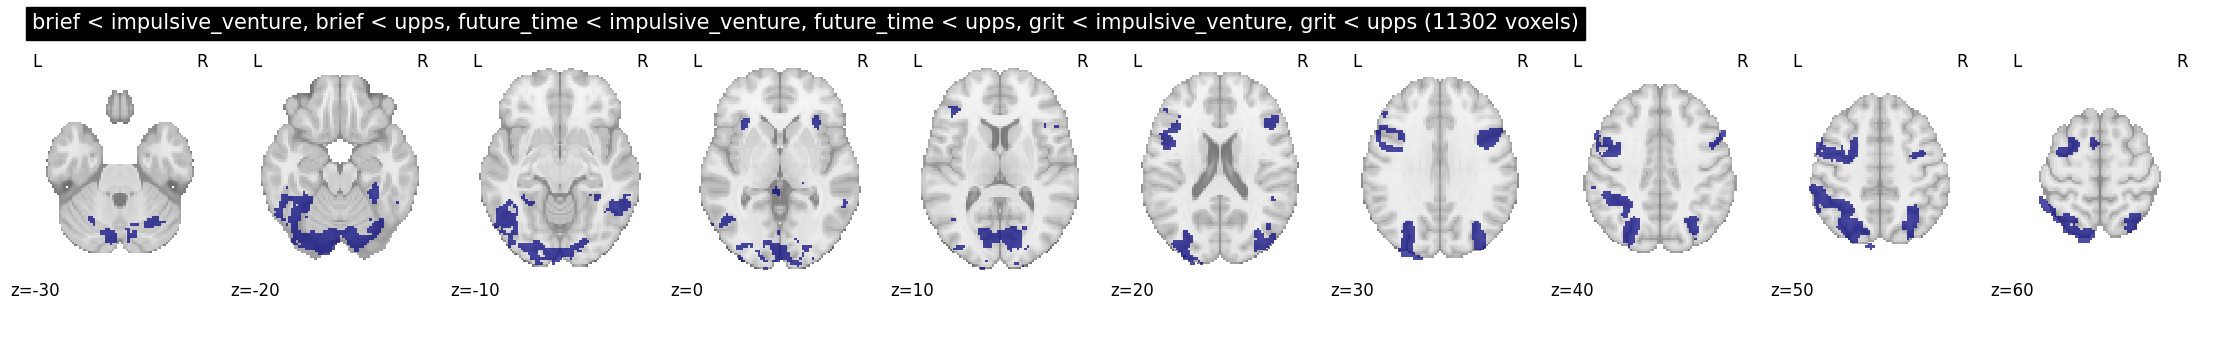

Integer 174248: 307 voxels -> brief < grit, brief < impulsive_venture, brief < upps, future_time < impulsive_venture, future_time < upps, grit < impulsive_venture, grit < upps (largest cluster: 179)


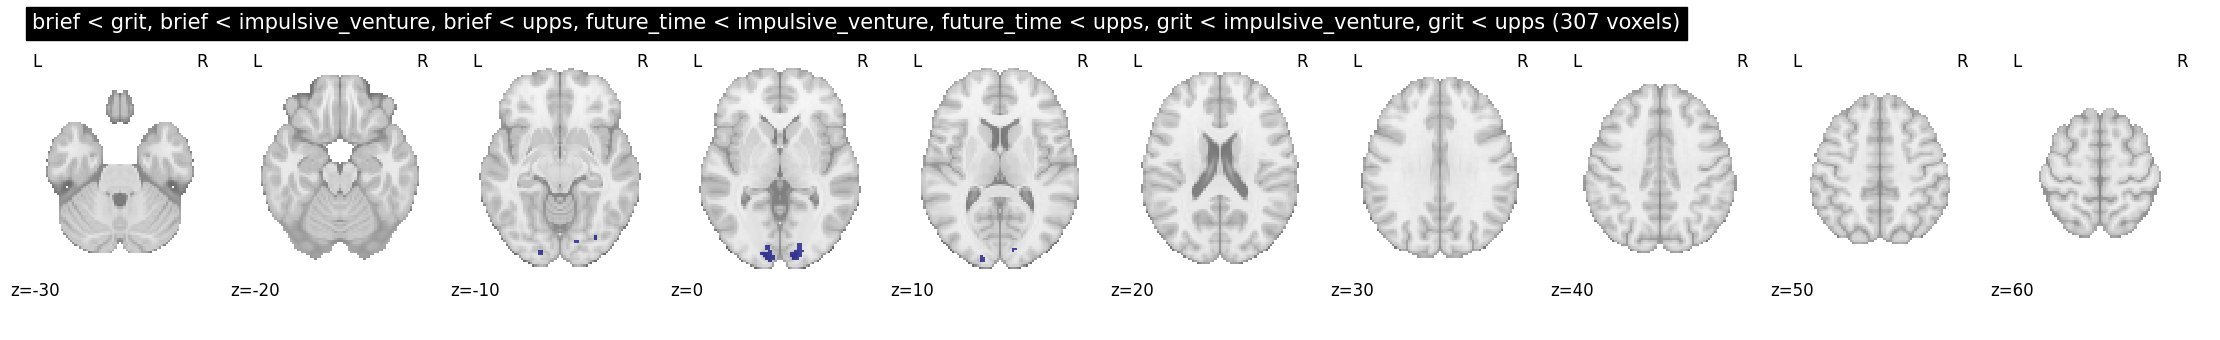

Integer 262144: 963 voxels -> impulsive_venture > upps (largest cluster: 172)


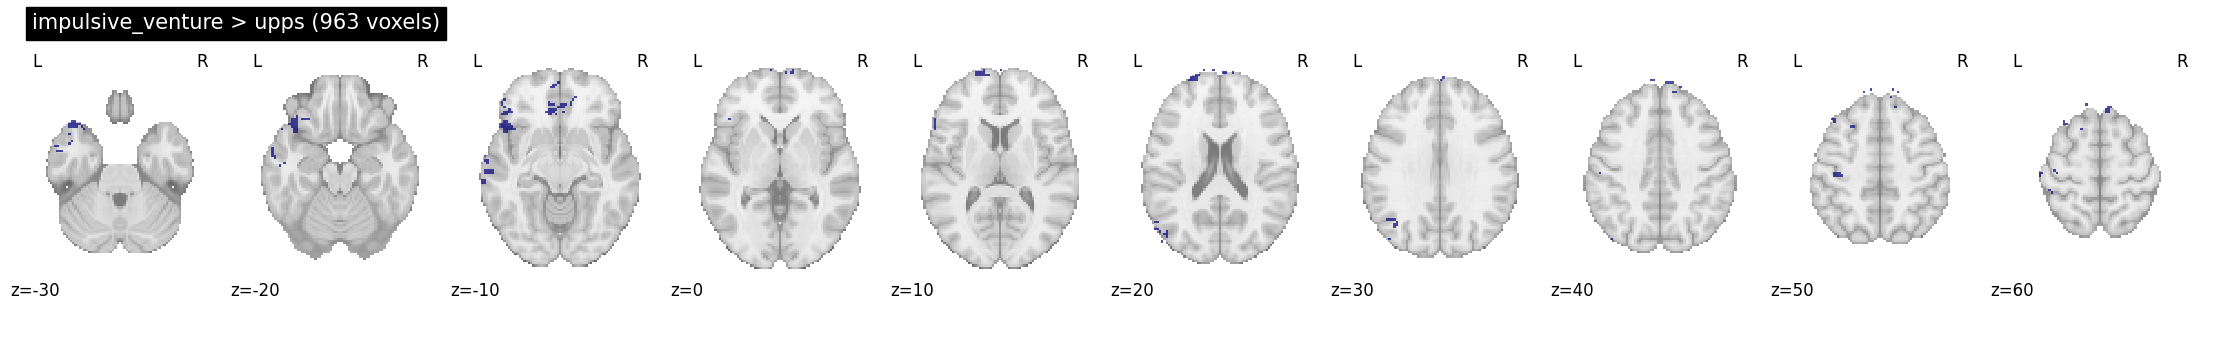

Integer 266304: 887 voxels -> brief > upps, future_time > upps, impulsive_venture > upps (largest cluster: 250)


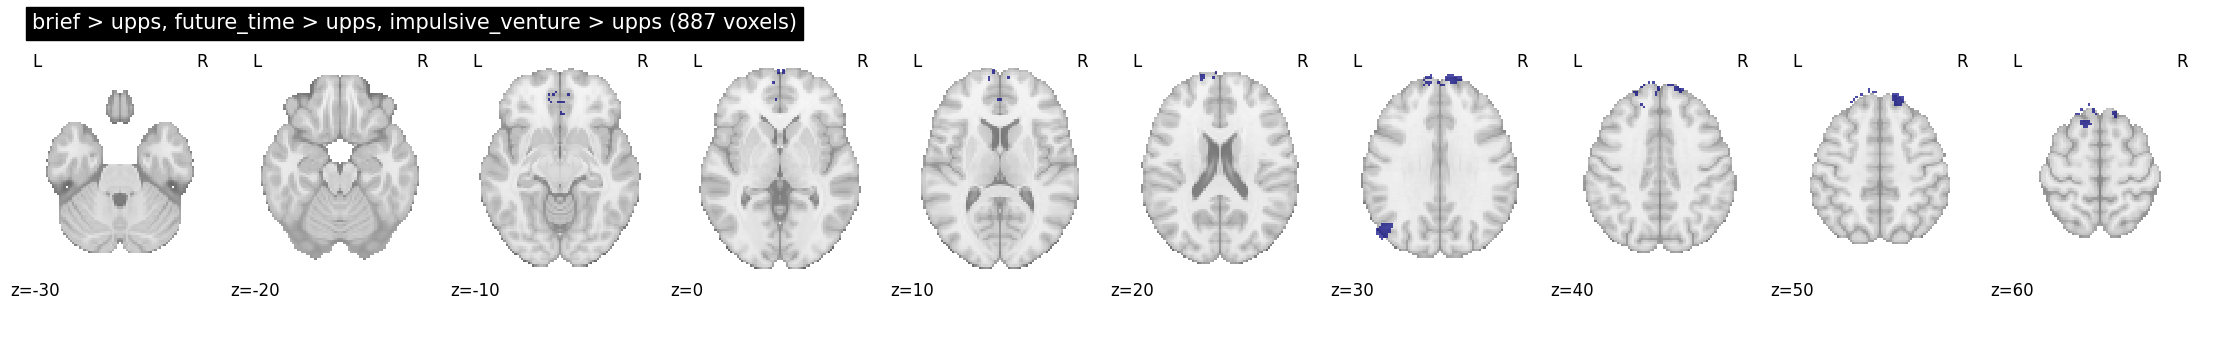

Integer 294912: 729 voxels -> grit < impulsive_venture, impulsive_venture > upps (largest cluster: 340)


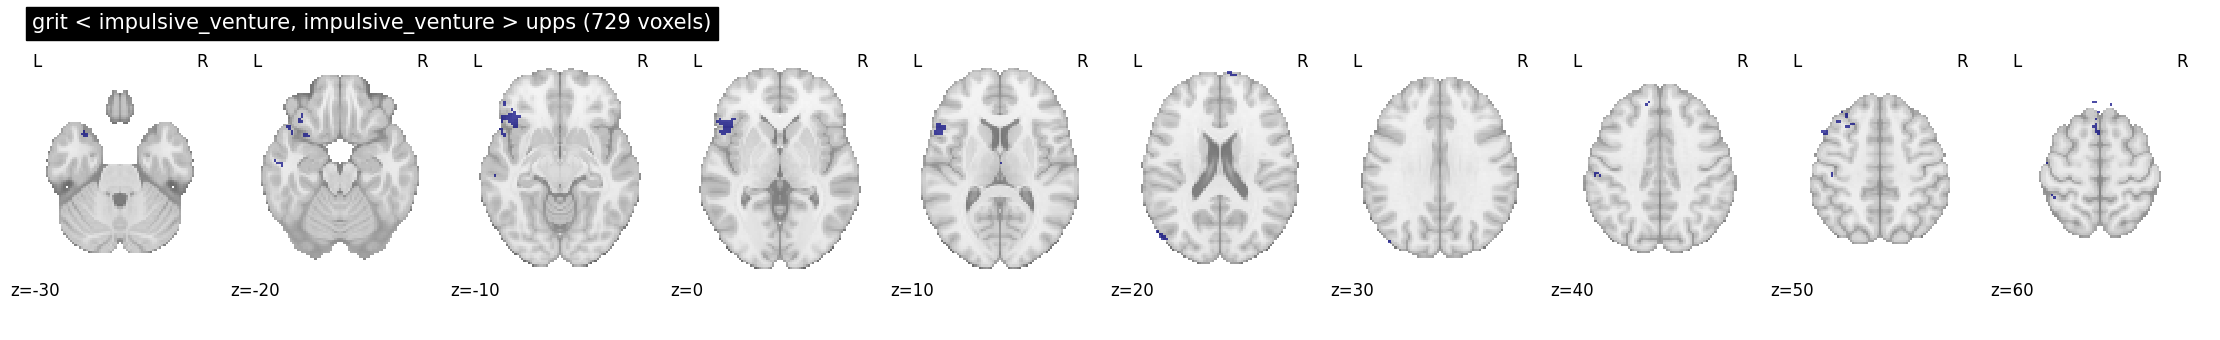

Integer 296992: 1395 voxels -> brief < impulsive_venture, future_time < impulsive_venture, grit < impulsive_venture, impulsive_venture > upps (largest cluster: 197)


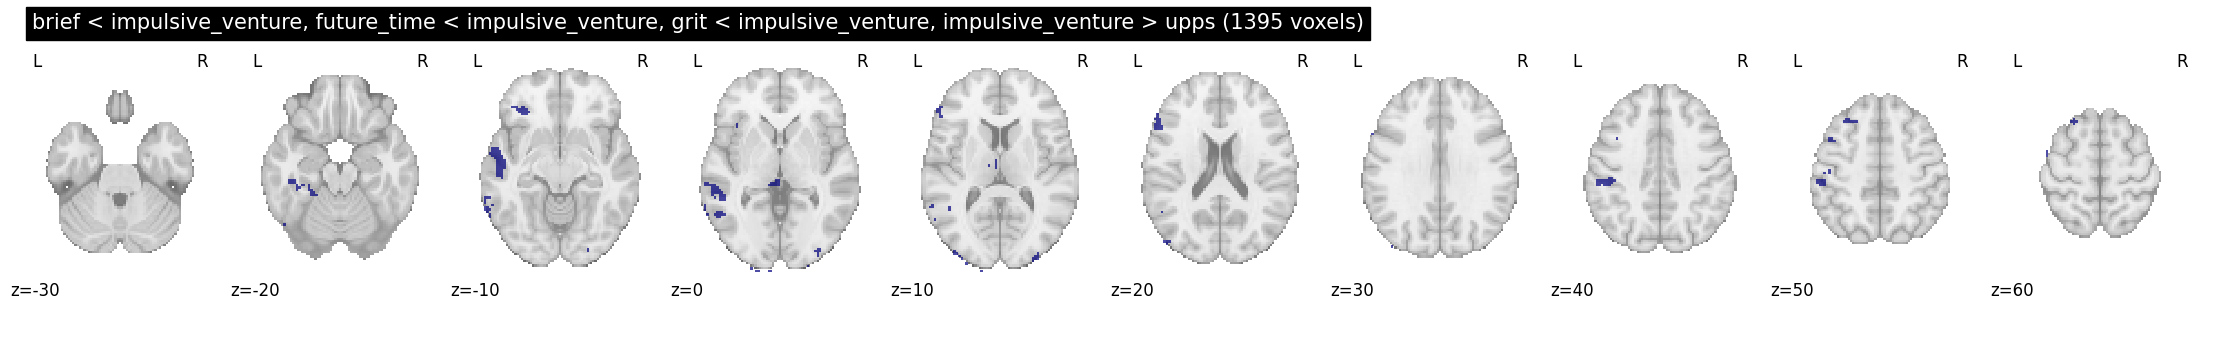

Integer 297120: 302 voxels -> brief < impulsive_venture, brief < upps, future_time < impulsive_venture, grit < impulsive_venture, impulsive_venture > upps (largest cluster: 158)


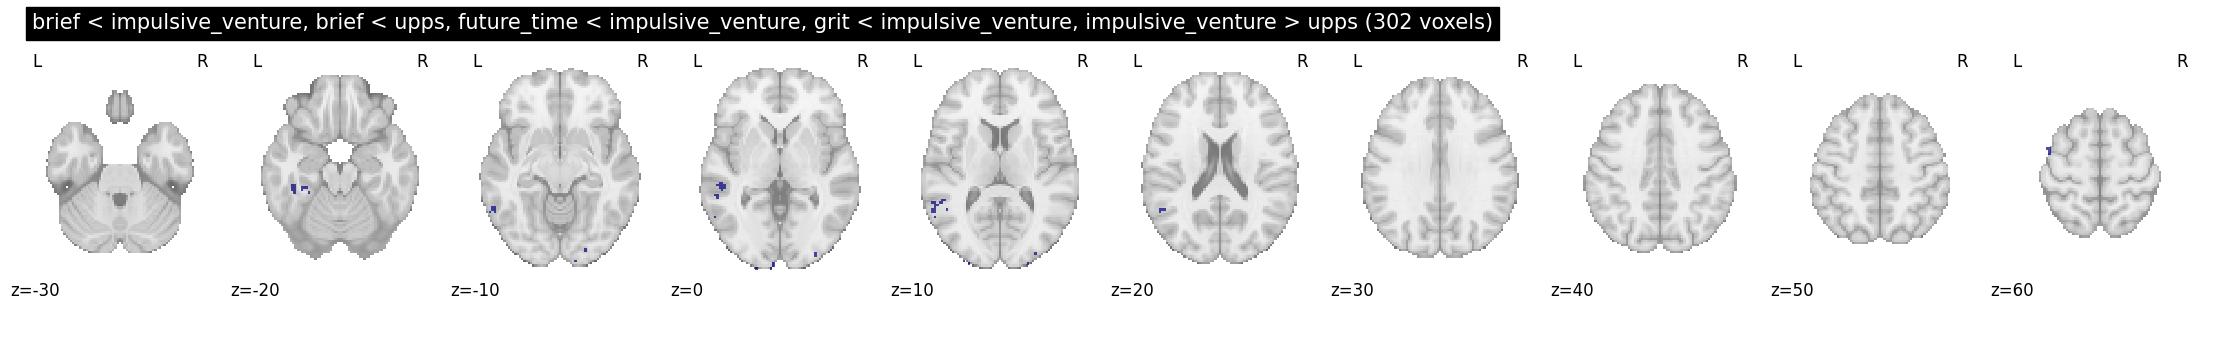

Integer 331840: 787 voxels -> brief > upps, future_time > upps, grit > upps, impulsive_venture > upps (largest cluster: 684)


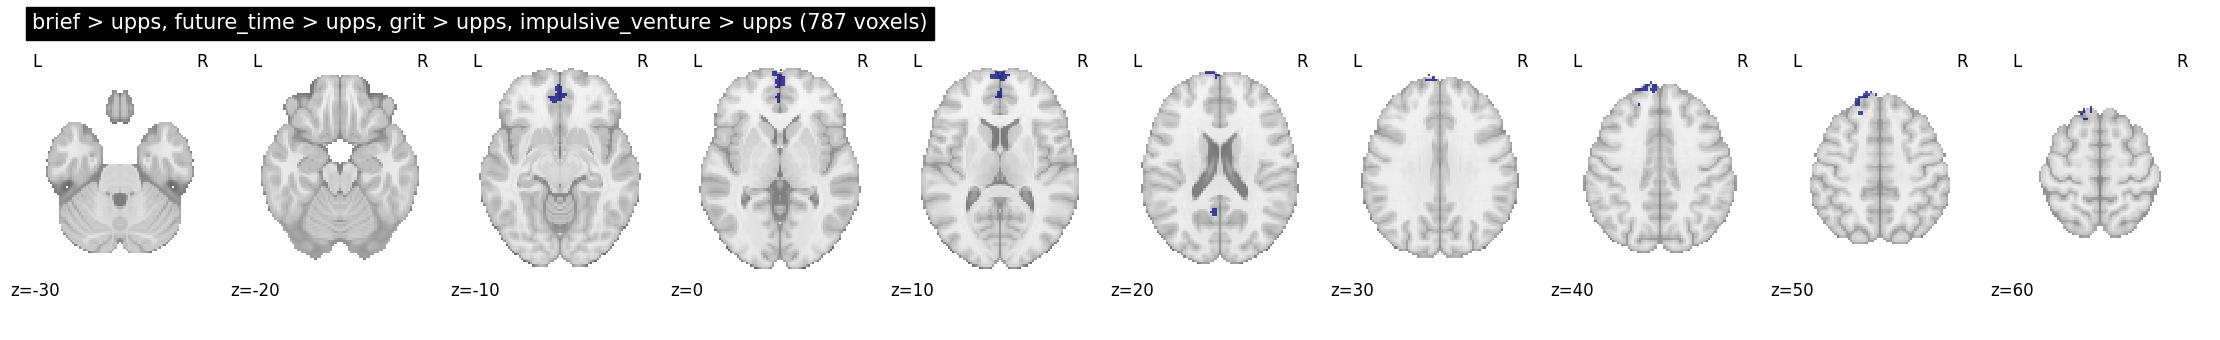

Integer 331844: 238 voxels -> brief > grit, brief > upps, future_time > upps, grit > upps, impulsive_venture > upps (largest cluster: 188)


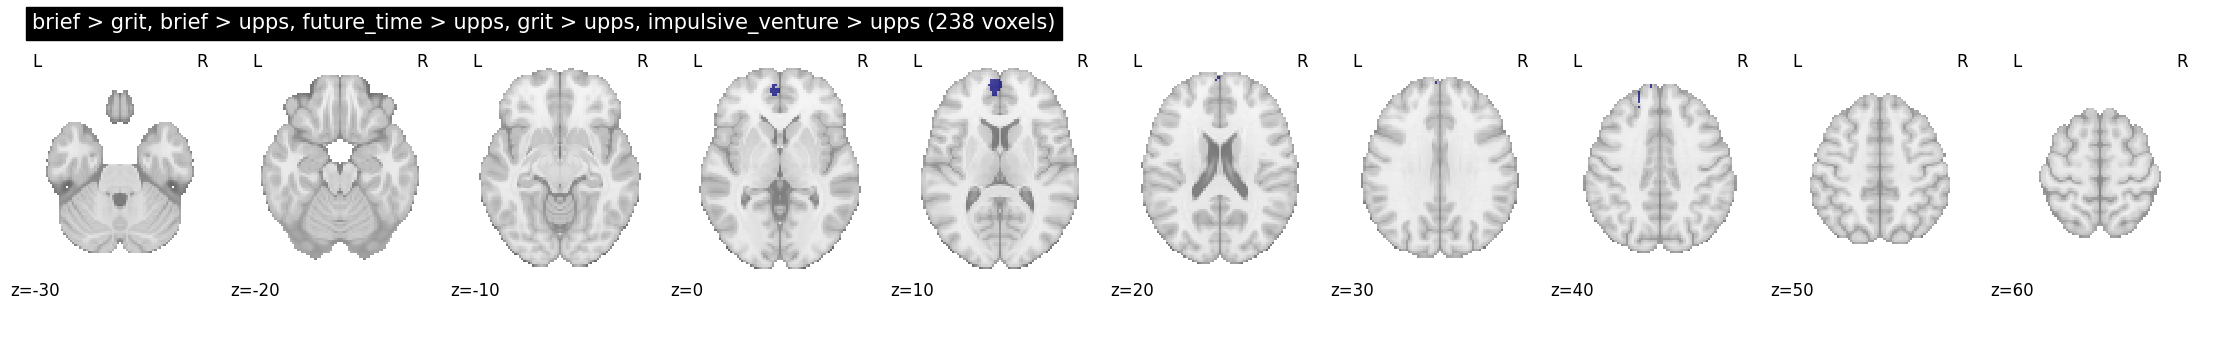

Integer 364608: 197 voxels -> brief > upps, future_time > upps, grit < impulsive_venture, grit > upps, impulsive_venture > upps (largest cluster: 162)


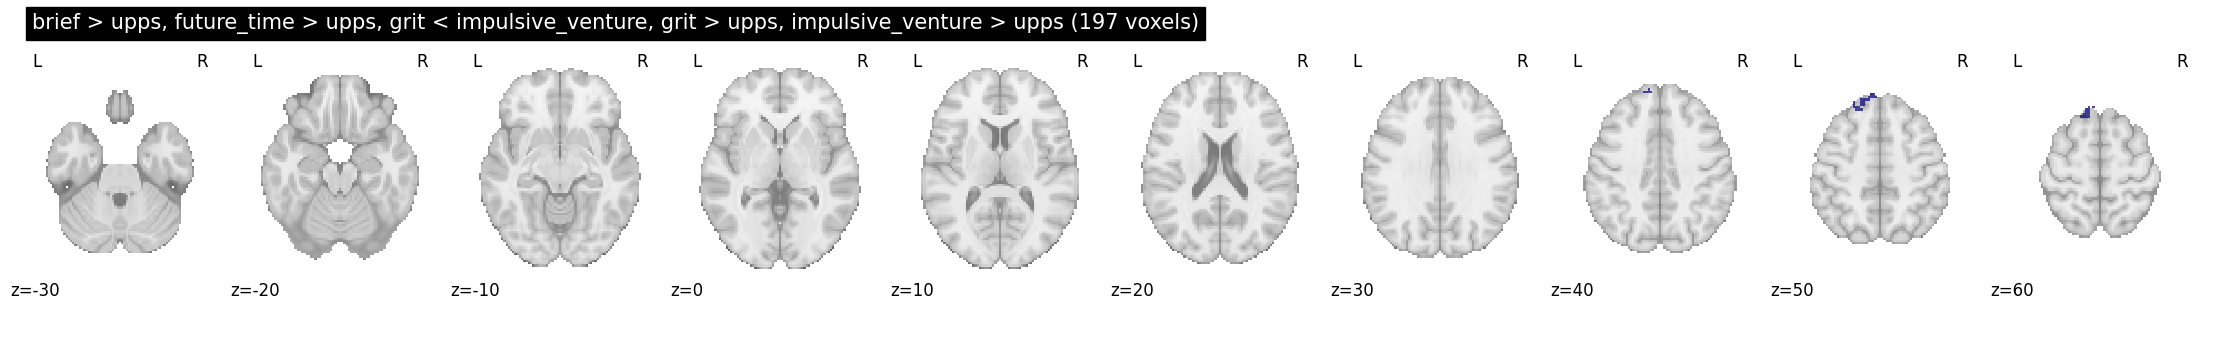

Integer 436384: 961 voxels -> brief < impulsive_venture, brief < upps, future_time < impulsive_venture, future_time < upps, grit < impulsive_venture, grit < upps, impulsive_venture > upps (largest cluster: 380)


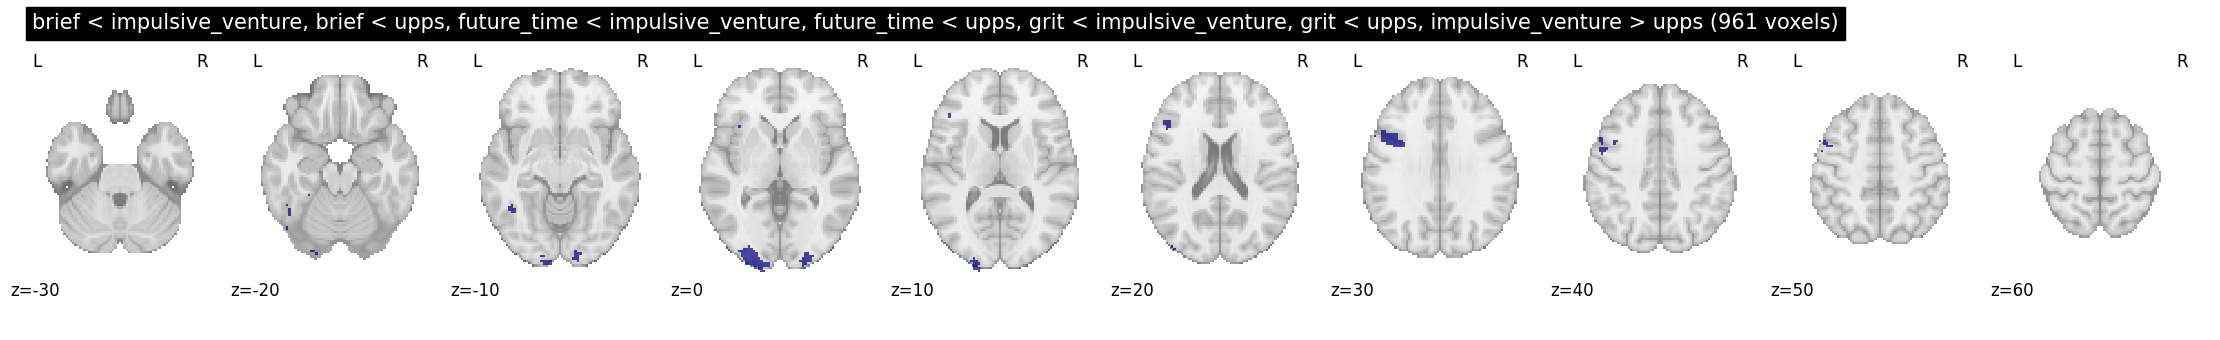

Integer 663680: 897 voxels -> brief < upps, future_time < upps, grit < upps, impulsive_venture < upps (largest cluster: 282)


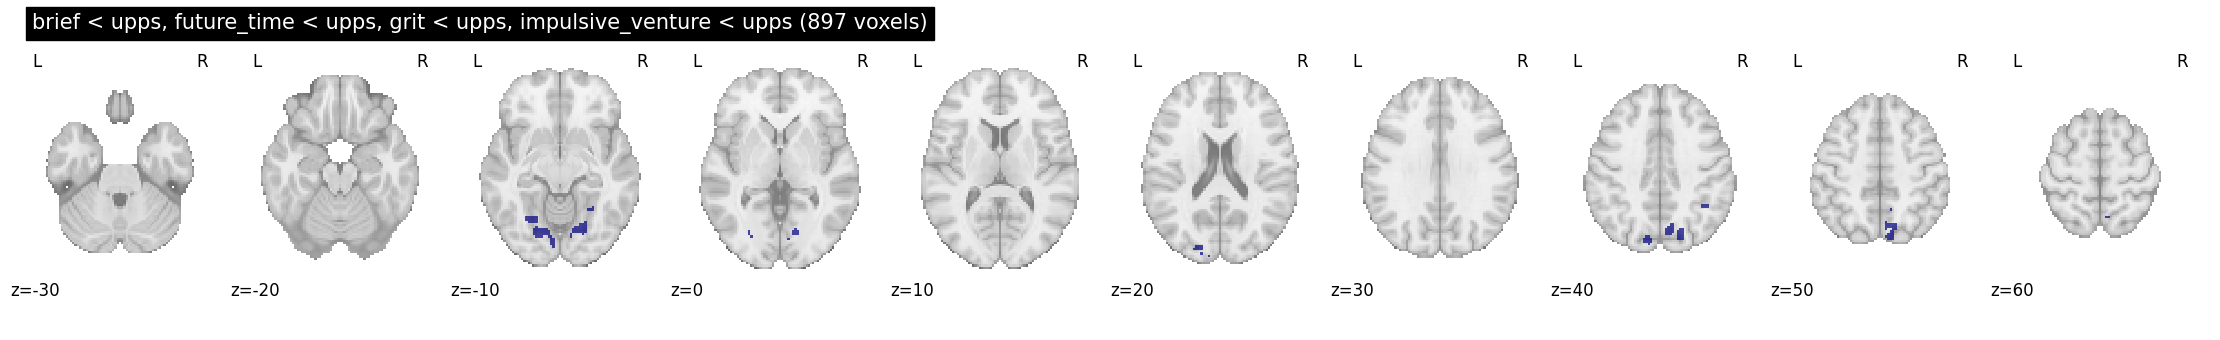

In [12]:
from scipy.ndimage import label

# Example inside your loop
for val, n_vox in voxel_counts.items():
    if val == 0:
        continue  # skip F-only (0)

    # Create a binary map for this integer
    data = (integer_map == val).astype(np.int32)

    # Label connected components
    labeled_array, num_features = label(data)  # 6-connectivity by default for 3D

    # Compute size of each connected component
    component_sizes = np.bincount(labeled_array.ravel())[1:]  # skip background (0)

    # Only plot if any component has at least 30 voxels
    if component_sizes.size == 0 or component_sizes.max() < 150:
        continue

    img_val = new_img_like(integer_img, data)
    label_text = ', '.join(interpret_dict[val])
    print(
        f'Integer {val}: {n_vox} voxels -> {label_text} (largest cluster: {component_sizes.max()})'
    )

    plot_roi(
        img_val,
        display_mode='z',
        cut_coords=z_slices,
        title=f'{label_text} ({n_vox} voxels)',
        colorbar=False,
    )
    plt.show()